# Collaborative Filtering
Problem setting: there are many products and many users. In collaborative filtering, we look at the products the current user has used or liked, find others who have liked similar products, and recommend products that those other users have used or liked.

## Latent Factors
The foundational idea is that of "latent factors." We don't really need to know much of anything about the users or about the products except for which users have used/liked which products. But we assume there are some underlying unifying characteristics about these users and/or products. Netflix could recommend a bunch of '70s sci-fi without possessing any concept of '70s sci-fi. But that underlying concept is still what we are getting at.

## The Data 
We will use a subset of the `MovieLens` dataset. The full dataset contains tens of millions of movie rankings (a rating, a movie ID, and a user ID). We will use a subset of 100,000 of these rankings.

In [1]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [2]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                     names=['user', 'movie', 'rating', 'timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Compared to the full dataset, this subset contains some of the most popular (most reviewed) movies, and some of the most prolific reviewers of movies. What we are ultimately interested in is being able to assign predicted ratings to user-movie combinations that do not have ratings.

## Learning Latent Factors
We can imagine a circumstance where each movie is rated according to a handful of factors, and each user has a certain proclivity for those factors. Maybe we have `['recency', 'high action', 'long movie']`. A movie with values `[-0.9, 0, 0.7]` would be an old, medium-action, long movie. A user's preferences can be expressed in the same way. A user who likes new, high-action, short movies could be represented with the list `[0.8, 0.9, -0.7]`. We could determine how likely the user is to like our old movie by taking the dot product. We end up with -1.21 -- a poor match (quality of match here could range from -3 to 3).

In the model of interest in this chapter, though, we want the *model* to learn the latent factors so we don't have to. That involves the following steps:

1. Randomly initialize some parameters. These parameters are a set of latent factors for each movie and user. We need to choose how many to use, but we do *not* choose what they mean.
2. Calculate predictions. We can take the dot products of the parameters for each movie and user to assign a predicted score to each movie/user combination.
3. Calculate the loss. We can use any loss function; for now we'll use MSE for simplicity. With these steps in place, we can optimize our parameters with SGD. 

My question at this phase is: how do we choose to optimize viewer vs. movie parameters? Is there any meaningful difference?

## Preparing the DataLoaders
We start by getting movie titles and corresponding IDs

In [3]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1',
                    usecols=(0,1), names=('movie', 'title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [4]:
# Merge with ratings
ratings = ratings.merge(movies, on = "movie")
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [5]:
# Build a DataLoaders
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,650,"Bridges of Madison County, The (1995)",2
1,616,Mad City (1997),3
2,167,Mr. Smith Goes to Washington (1939),4
3,224,Phenomenon (1996),3
4,327,Scream (1996),4
5,10,Sabrina (1954),4
6,56,Multiplicity (1996),4
7,311,Fargo (1996),1
8,721,Volcano (1997),3
9,479,"Princess Bride, The (1987)",5


### Doing this in PyTorch
We can't use the pandas crosstab presentation directly. We need tensors.

In [6]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5 # Can adjust this however we want

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

One challenge is how to look up our user-movie correspondences (i.e. to find the indices). To do this, we replace our indices with one-hot coded vectors.

In [7]:
one_hot_3 = one_hot(3, n_users).float()
one_hot_3[1:10]

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [8]:
user_factors.t() @ one_hot_3

tensor([-0.9431, -1.8060, -1.6114, -0.8795, -0.2871])

This is the same as if we used `user_factors[3]`. This vector-based approach resembles what is occurring behind the scenes. Behind the scences there is an "embedding matrix" that is multiplied to find indices.

As discussed above, in this model, we're not specifying what the factors of interest are. We're letting the model figure it out for itself by working through the connections between users and movies. We'll be able to see what sorts of movies are "grouped" at the end and to isolate genres, blockbusters, etc.

## Collaborative Filtering Model from Scratch
(begins with a little review of classes). We will use the PyTorch `module` class to define our own dot product class. I updated the original version from p261 to include the addition of `y_range` from 262, ensuring our predictions fall between 0 and 5.

In [9]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range = (0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range=y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        # We defined y_range as a tuple so *self.y_range unpacks it.
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [10]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,0.990264,0.984855,00:10
1,0.841716,0.898693,00:09
2,0.660927,0.865518,00:08
3,0.462861,0.872845,00:08
4,0.351368,0.878040,00:08


So we now have a working model. What are the next steps? Some missing pieces:
- Some viewers are just more positive/negative and some movies are just good/bad. How do we account for this?

Answer: we currently just have weights. We also need a bias term. One bias term for each viewer and each movie will allow us to adjust for these considerations.

In [11]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users,1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies,1)
        self.y_range=y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users*movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)
    
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,1.009261,1.000437,00:11
1,0.900416,0.898409,00:09
2,0.699724,0.859263,00:08
3,0.487397,0.864799,00:10
4,0.358212,0.869992,00:12


## Weight Decay
Our model actually got worse by the end. Oops. Next time, we'll get into *weight decay* as a method of solving this. Weight decay is L2 regularization. In L2 regularization (ridge regression?) we add the sum of squared weights to the loss function. This discourages overfitting by encouraging lower weights in general. This can discourage overfitting by preventing the model from assigning very high weights associated with certain training situations (?).

We can pass `wd` as an argument to `learn.fit_one_cycle`. Different values can have different results (we can vary the degree of regularization).

In [12]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5,5e-3,wd=0.1)

epoch,train_loss,valid_loss,time
0,0.957417,0.943936,00:10
1,0.857454,0.866373,00:10
2,0.708513,0.822341,00:10
3,0.603905,0.810551,00:13
4,0.478483,0.811706,00:09


A definite improvement.

## Creating our own embedding module
We haven't thought much about what `embedding` actually is/does, so we're going to recreate it without using the class.

In [13]:
class T(Module):
    def __init__(self): self.a = torch.ones(3)

L(T().parameters())

(#0) []

What does the above illustrate? Optimizers need to be able to get parameters from a module's `parameters` method, but this is not automatic.

In [14]:
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

All `PyTorch` modules use `nn.Parameter` for any/all trainable parameters. For this reason, we have not needed to explicitly call `nn.Parameter`. For example:

In [16]:
class T(Module):
    def __init__(self): self.a = nn.Linear(1,3,bias=False)
t = T()
L(t.parameters()), type(t.a.weight)

((#1) [Parameter containing:
 tensor([[-0.7359],
         [-0.2971],
         [ 0.4927]], requires_grad=True)],
 torch.nn.parameter.Parameter)

### Create a tensor as a parameter, with random initialization

In [24]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0,0.1))

In [25]:
create_params([3,4])

Parameter containing:
tensor([[ 0.1754, -0.1162, -0.0152, -0.0579],
        [ 0.0509, -0.0623, -0.2051, -0.1134],
        [-0.1045, -0.1003, -0.1089, -0.0824]], requires_grad=True)

In [38]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range=y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

OK, a quick reminder here. in `forward`, x refers to our input data. What do our input data look like? A two-column table of user IDs and movie IDs. Let's explore this step by step.

In [70]:
x,y = dls.one_batch()
user_factors = create_params([n_users, n_factors])
movie_factors = create_params([n_movies, n_factors])

In [71]:
xuser = x[:,0]
xuser

tensor([542, 551, 726, 833, 854, 868, 870, 533, 346, 541, 712, 385, 262, 916,
        833, 658, 721, 823, 606, 468, 682, 489,  94, 308, 643,  63, 551, 593,
        149, 248, 453, 399, 567,  81, 381, 382, 897, 151, 391, 296, 354, 763,
        663,  16, 846, 801, 650, 268, 222, 142, 860, 405, 620, 347, 456, 176,
        132, 148, 110, 130, 406, 757, 710,  13])

In [49]:
user_factors.shape

torch.Size([944, 5])

In [55]:
(user_factors[xuser]).shape, xuser.shape

(torch.Size([64, 5]), torch.Size([64]))

In [57]:
user_factors[[1,2,4]]

tensor([[ 0.0781,  0.0762,  0.1623,  0.1272, -0.1008],
        [ 0.0773, -0.0719, -0.1299,  0.2710, -0.0511],
        [-0.1808, -0.1901, -0.0663,  0.0985, -0.0308]],
       grad_fn=<IndexBackward>)

So it looks like we're treating the user inputs as indices.

In [74]:
xuser.max()

tensor(916)

OK, so how does that work if we have 1649 as our max user but only 944 user_factors? Is x rescaled in some way? NO. We don't have 1649 users. `x.max` included the movie indices.

In [75]:
xmovie = x[:,1]
xmovie.max()

tensor(1619)

In [77]:
movie_factors.shape

torch.Size([1665, 5])

In [69]:
xuser

tensor([840, 339, 328, 198, 215, 816, 463, 719, 210, 912, 230, 454, 450,  95,
        496, 899, 699, 405, 326, 671, 907, 271, 472,   5, 715, 389, 919, 406,
        593, 374, 503,  69, 385,  24, 749, 497, 894,  18, 727, 506, 493, 207,
        688, 181, 898, 798, 843,  59, 128,  59, 104, 795, 690, 437, 897, 908,
        747, 440, 233, 658, 509, 846, 887,  56])

In [78]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func = MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.999838,0.984600,00:10
1,0.804278,0.851267,00:09
2,0.649053,0.841685,00:09
3,0.493710,0.838438,00:09
4,0.384005,0.840203,00:09


So this is in line with our earlier model. So what, then, is an embedding? What does this have to do with indexing? WELL. We have our used factors indexed to a user. We have our movie factors indexed to a movie. We have a batch with *the same number of users and movies* because it's the ratings assigned by each user to the corresponding movie. Let's go through the steps manually.

In [79]:
x,y = dls.one_batch()
user_factors = create_params([n_users, n_factors])
movie_factors = create_params([n_movies, n_factors])
user_factors.shape, movie_factors.shape

(torch.Size([944, 5]), torch.Size([1665, 5]))

In [80]:
users = user_factors[x[:,0]]
movies = movie_factors[x[:,1]]
users.shape,movies.shape

(torch.Size([64, 5]), torch.Size([64, 5]))

So now we have objects of the same size. Excellent. We started out with x as a two-column table of users and correpsonding movies, and now we have `users` and `movies`, each of which contain the 1x5 parameter tensors. Multiplying them and taking the sum gives us a set of ratings.

In [81]:
res = (users*movies)
res

tensor([[-8.1124e-04,  1.0243e-04, -4.5069e-03, -1.3149e-04, -1.4269e-03],
        [-2.4590e-03, -2.9902e-04,  1.2950e-02,  5.6369e-03,  1.1046e-03],
        [ 8.2924e-03, -2.2118e-03,  1.9761e-02,  2.7960e-02, -1.2623e-02],
        [ 2.1267e-03, -1.2918e-02, -9.1278e-04,  6.3873e-04, -1.8735e-03],
        [-7.5046e-05, -1.7126e-03, -3.6889e-03, -5.0859e-03, -2.7960e-04],
        [ 4.4283e-03,  4.2261e-03,  2.9040e-03,  8.0094e-03, -1.1118e-03],
        [ 7.3242e-03, -6.2349e-04,  9.1704e-03, -4.9636e-03,  1.1910e-03],
        [ 7.0370e-03, -5.5093e-03,  2.3006e-02, -1.8674e-03, -3.8760e-03],
        [ 4.1600e-03, -2.1118e-04, -3.4236e-02,  2.4941e-03,  5.3758e-03],
        [-4.5163e-06,  1.3069e-03,  5.5442e-04, -2.9947e-02,  4.9258e-03],
        [-2.0122e-03,  7.4862e-04, -1.5255e-03, -9.7495e-03, -2.2546e-04],
        [-6.8505e-03,  8.5523e-03,  2.4345e-03,  7.7216e-03, -3.1324e-03],
        [ 3.2652e-03,  2.7617e-02,  2.9281e-03,  9.2022e-03,  6.7675e-04],
        [-4.4453e-03, -1.

In [84]:
res.sum(dim=1)

tensor([-6.7741e-03,  1.6934e-02,  4.1178e-02, -1.2939e-02, -1.0842e-02,
         1.8456e-02,  1.2099e-02,  1.8791e-02, -2.2417e-02, -2.3164e-02,
        -1.2764e-02,  8.7255e-03,  4.3690e-02,  9.6755e-03, -3.5715e-03,
         2.2787e-02,  4.4123e-03,  2.9634e-02, -3.0653e-03,  1.2383e-02,
        -8.6587e-02,  8.1895e-03,  1.6239e-02, -1.5341e-02,  2.5216e-03,
        -1.8055e-02, -1.2586e-02, -5.5735e-03, -1.6950e-02,  2.7017e-04,
         2.0326e-02,  2.0964e-02, -2.8130e-03, -1.4487e-04,  2.3668e-02,
         5.2738e-03, -3.8443e-03,  2.7091e-02,  1.1901e-02,  2.8366e-02,
         3.2831e-03,  2.1236e-02, -2.6186e-02, -1.1610e-02, -6.7135e-05,
        -3.2992e-02,  9.1328e-03, -5.2284e-02,  1.2847e-02,  1.5716e-03,
         2.9806e-02,  7.6193e-03, -1.0838e-02, -3.0146e-02,  3.0214e-03,
        -2.6961e-02, -1.5946e-02,  1.3183e-02,  1.2140e-02, -9.2357e-05,
         1.5011e-03,  5.4635e-03, -4.3460e-02,  4.4477e-03],
       grad_fn=<SumBackward1>)

Recall that `dim` specifies the dimension to *reduce*. So here we're reducing the columns and keeping one term per row. And now we have one rating for each row -- that is, for each movie/user combination in the batch.

Question -- are there not multiple reviews per user? How are user weights kept consistent? Answer -- users are treated as indices and the weight objects exist as totally separate objects.

# Interpreting Embeddings and Biases
Let's explore what our model has actually told us. First, we'll look at the lowest biases. These represent cases where, *even when users are well-matched to the other latent factors*, they still tend to assign low ratings.

In [85]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Grease 2 (1982)',
 'Mortal Kombat: Annihilation (1997)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Kansas City (1996)']

And the highest:

In [109]:
idxs = movie_bias.argsort()[-5:]
[dls.classes['title'][i] for i in idxs.flip(0)]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Rear Window (1954)',
 'Good Will Hunting (1997)',
 'Silence of the Lambs, The (1991)']

# The Easy Way
As usual, there is a way to do all of this using the `fastai` API.

In [110]:
learn = collab_learner(dls, n_factors=50, y_range=(0,5.5))
learn.fit_one_cycle(5,5e-3,wd=0.1)

epoch,train_loss,valid_loss,time
0,0.970786,0.944023,00:10
1,0.851556,0.869246,00:10
2,0.733228,0.829357,00:10
3,0.602670,0.814296,00:10
4,0.486138,0.815382,00:10


In [111]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

We can replicate the "most popular movie" analysis:

In [113]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Good Will Hunting (1997)',
 'L.A. Confidential (1997)',
 'Silence of the Lambs, The (1991)',
 'Shawshank Redemption, The (1994)']

## Embedding Distance
We can measure the "distance" between embedding vectors, basically with Euclidean distance.

In [121]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Titanic (1997)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1:5]
dls.classes['title'][idx]

(#4) ['Man in the Iron Mask, The (1998)','8 Seconds (1994)','Crimson Tide (1995)','Boys of St. Vincent, The (1993)']

## Bootstrapping the collab filtering model

The *bootstrapping* problem occurs when you have no users & no data to learn from. Or, similarly, limited data. Or, perhaps more commonly, what about when you have a brand new user? Some solutions involve:
- Use some "average" values
- Try to obtain and use some Metadata.

I am curious -- using metadata, given we have *latent* factors, how would we use the metadata to assign starting values?

# Deep Learning for Collaborative Filtering
I guess the above wasn't really a DL model? Was not multi-layer. So we'd need to get the results of the embedding lookup and concatenate them. This returns something we can pass through the series of linear layers and nonlinearities in the "usual way."

We can use different numbers of embedding factors since we'll be concatenating the matrices, not taking the dot products. Fastai has a function recommending sizes.

In [122]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [127]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act,1))
        self.y_range=y_range
        
    def forward(self,x):
        embs = self.user_factors(x[:,0]), self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [128]:
model = CollabNN(*embs)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5,5e-3,wd=0.01)

epoch,train_loss,valid_loss,time
0,0.956527,0.956170,00:12
1,0.891190,0.902305,00:15
2,0.841123,0.870318,00:14
3,0.803009,0.856235,00:12
4,0.783738,0.858033,00:14


In [131]:
# Of course, also an easy way.
learn = collab_learner(dls, use_nn=True, y_range=(0,5.5), layers=[100,50])
learn.fit_one_cycle(5,5e-3,wd=.005)

epoch,train_loss,valid_loss,time
0,0.961325,0.978483,00:18
1,0.899903,0.904707,00:17
2,0.842807,0.867242,00:16
3,0.748023,0.845886,00:16
4,0.742800,0.848701,00:16


SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.00363078061491251)

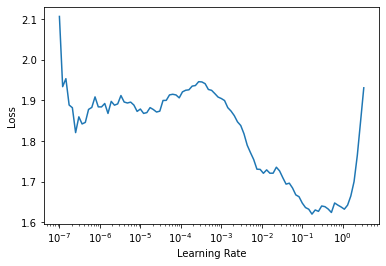

In [137]:
learn = collab_learner(dls, use_nn=True, y_range=(0,5.5), layers=[100,50])
learn.lr_find()

I would not change the learning rate based on this, so, while I'm sure there are more ways to improve this, I think we're good for now.